In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [5]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59722.75 # t_max_B
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


In [6]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

distmod = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(distmod))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

## 1-D DDet models

In [12]:
import h5py

spec1 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
spec1 = data_binning(np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=5)
spec2 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt')
spec3 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii')

### Polin+2019

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.625


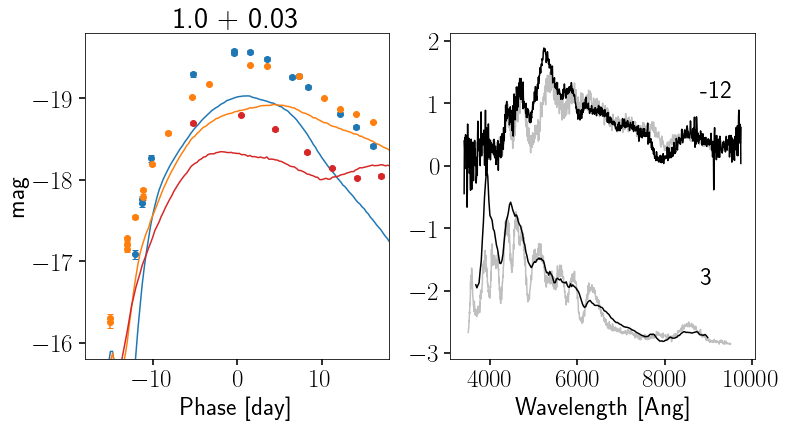

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.875


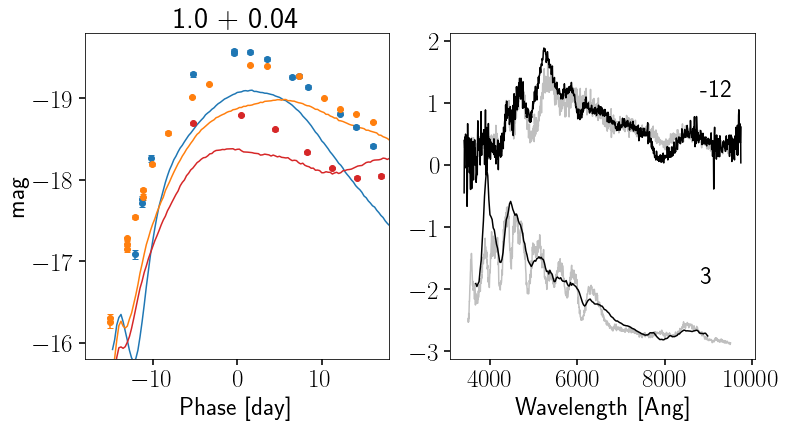

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.875


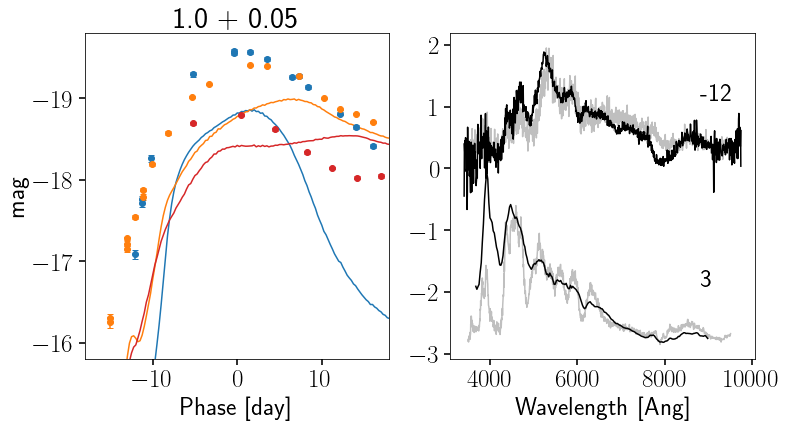

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.875


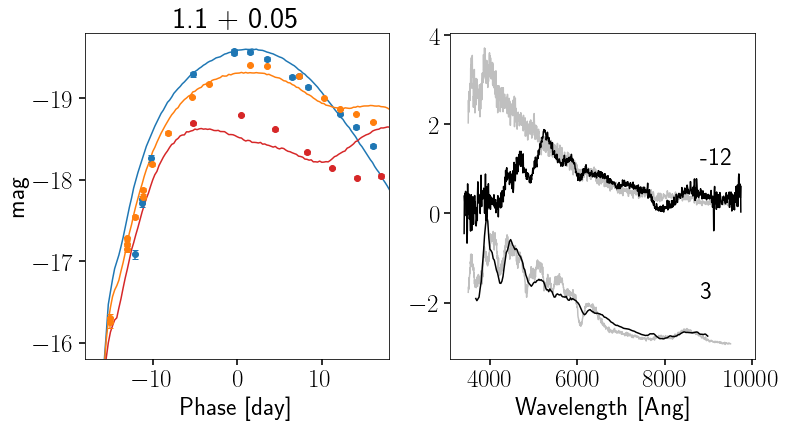

In [16]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    # t_max = 17

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color="tab:blue")
    ax[0].plot(time[ind] - t_max, fit_r, color="tab:orange")
    ax[0].plot(time[ind] - t_max, fit_i, color="tab:red")

    ax[0].errorbar(
        (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_g["mag"] - distmod,
        yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:blue",
    )
    ax[0].errorbar(
        (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_r["mag"] - distmod,
        yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:orange",
    )
    ax[0].errorbar(
        (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_i["mag"] - distmod,
        yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:red",
    )
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel("Phase [day]")
    ax[0].set_ylabel("mag")
    ax[0].set_title(f"{mc} + {ms}")

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.1, 2.52])
    specs = [spec1, spec2]
    for k in range(2):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        ax[1].plot(
            wv0[idx_wv],
            Flam[phase_idx][idx_wv]
            / np.median(Flam[phase_idx][(wv0 > 5500) & (wv0 < 6500)])
            - 3 * k,
            color=".5",
            alpha=0.5,
        )
        ax[1].plot(
            specs[k][:, 0] / (1 + z),
            specs[k][:, 1]
            / np.median(
                specs[k][:, 1][
                    (specs[k][:, 0] / (1 + z) > 5500)
                    & (specs[k][:, 0] / (1 + z) < 6500)
                ]
            )
            - 3 * k,
            color="k",
        )
        ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 3 * k, color="k")
    ax[1].set_xlabel("Wavelength [Ang]")
    plt.show()

In [17]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)],
            flt=np.loadtxt("./filters/Bessell_B.dat"),
        )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    np.savetxt(
        f"./Polin+19_model/mc_{mc}_ms_{ms}_lc.txt",
        np.array([time[ind], fit_g, fit_r, fit_i, fit_B]).T,
        fmt="%.2f %.3f %.3f %.3f %.3f",
        header="Time ZTFg ZTFr ZTFi B",
    )

    idx_wv = (wv0 > 3000) & (wv0 < 9500)
    phases = np.array([-13, -12, -11, 0, 1, 2, 3])
    for k in range(len(phases)):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        np.savetxt(
            f"./Polin+19_model/mc_{mc}_ms_{ms}_phase_{phases[k]}_spec.txt",
            np.array(
                [
                    wv,
                    Flam[phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.625
15.875
14.875
16.875


### Shen+2021

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


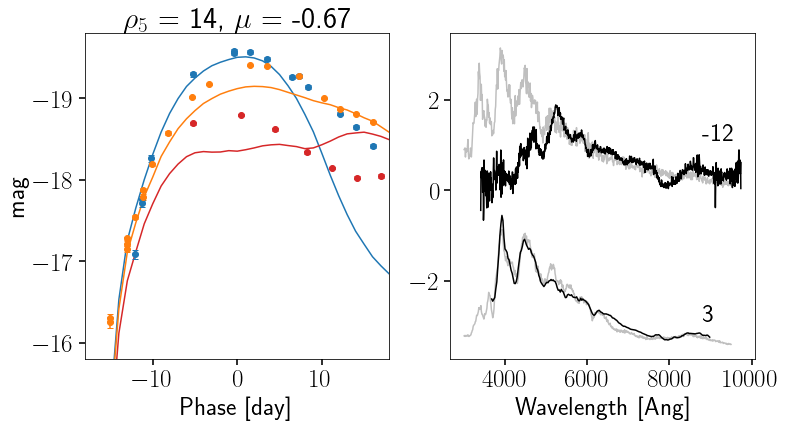

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


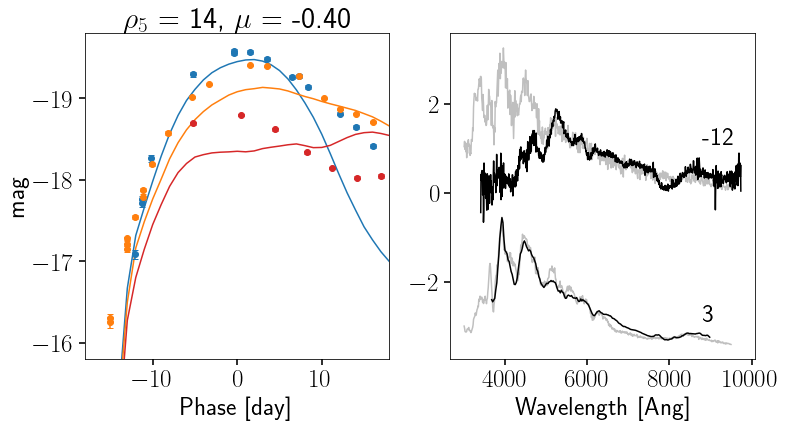

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


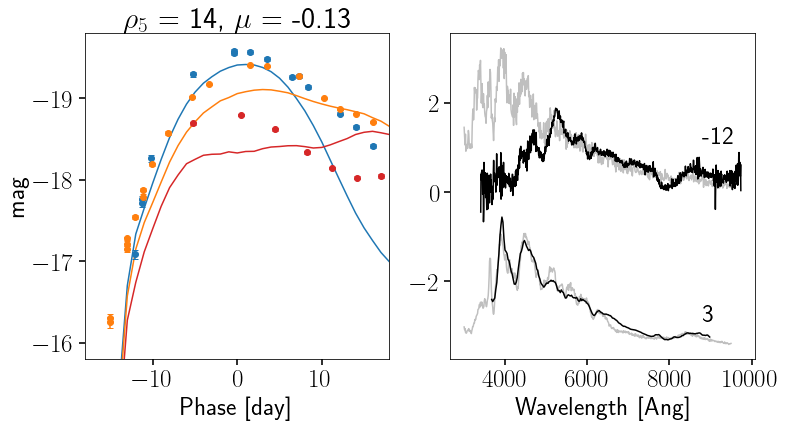

In [18]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_??e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


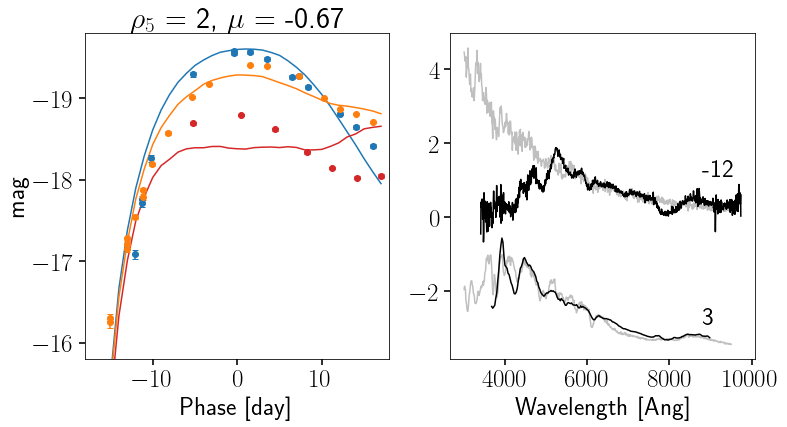

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


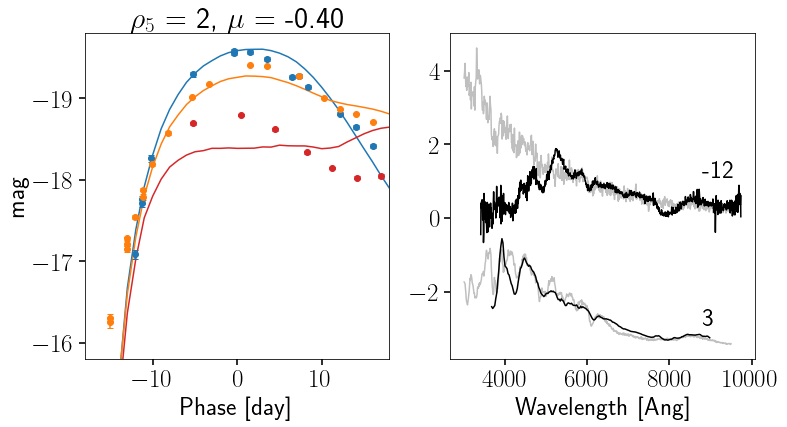

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


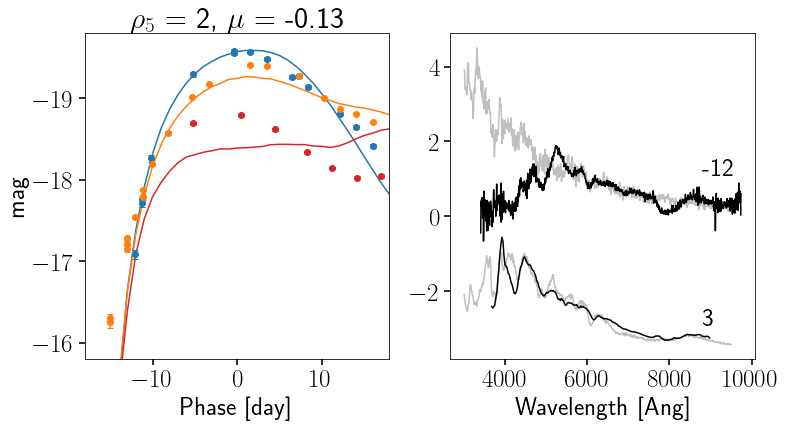

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


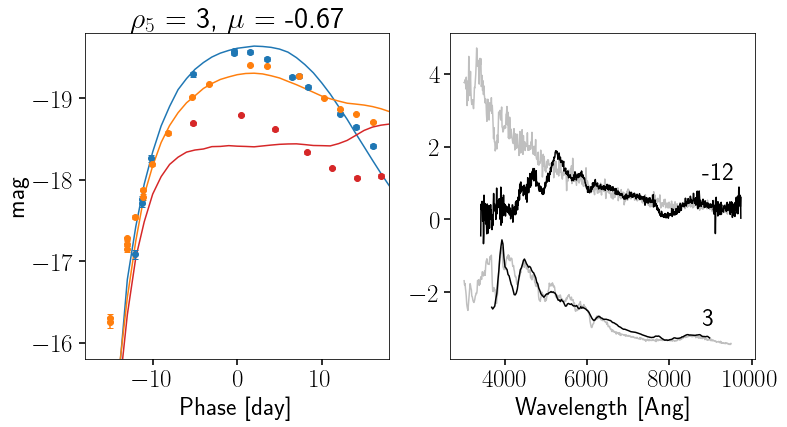

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


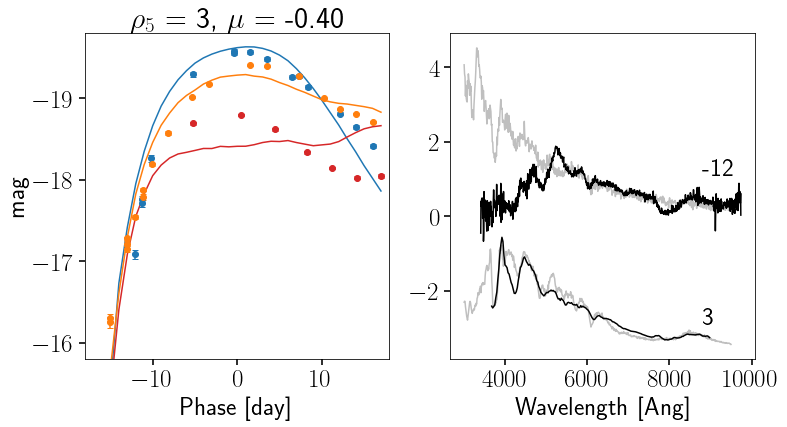

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


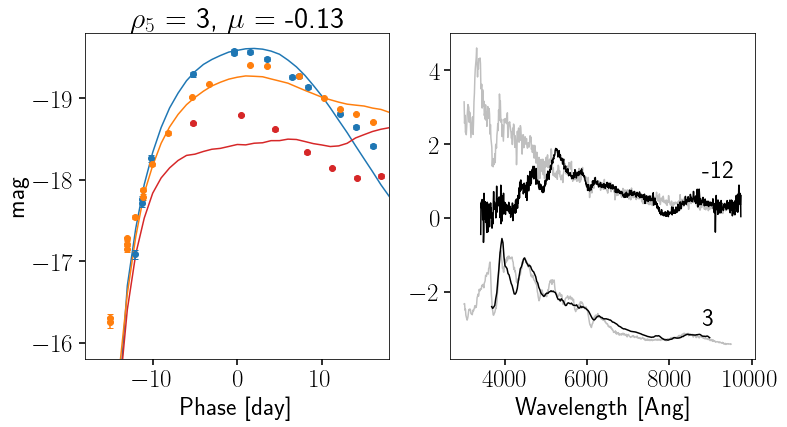

In [19]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.10_*e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

17.25


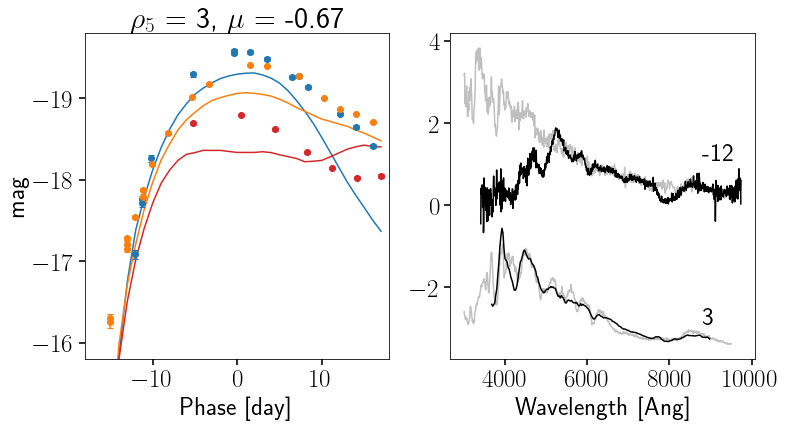

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


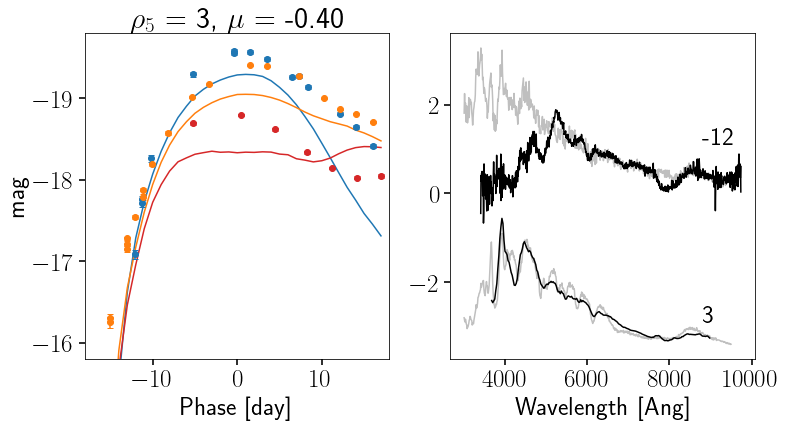

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


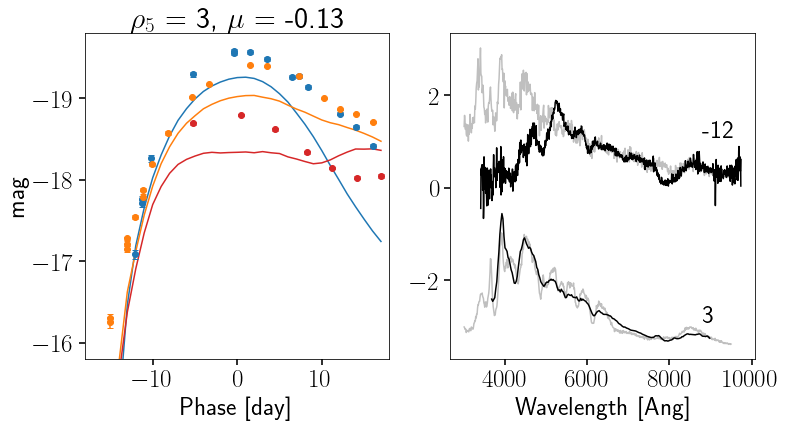

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


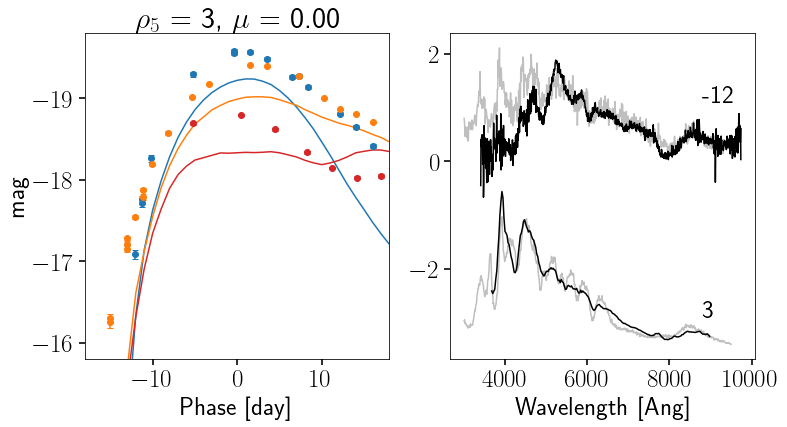

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


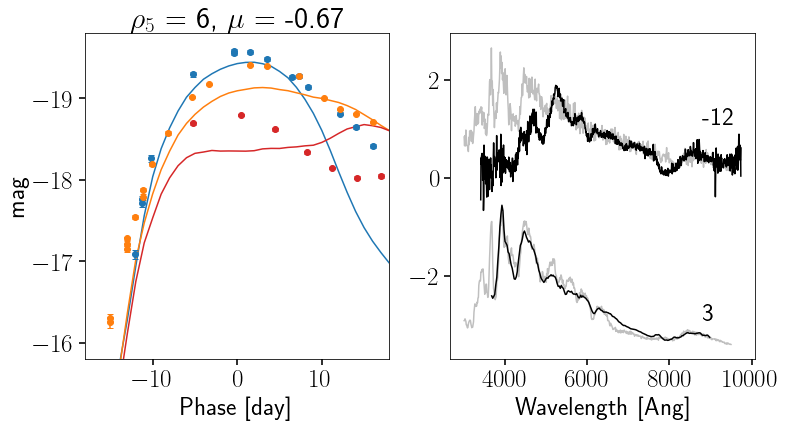

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


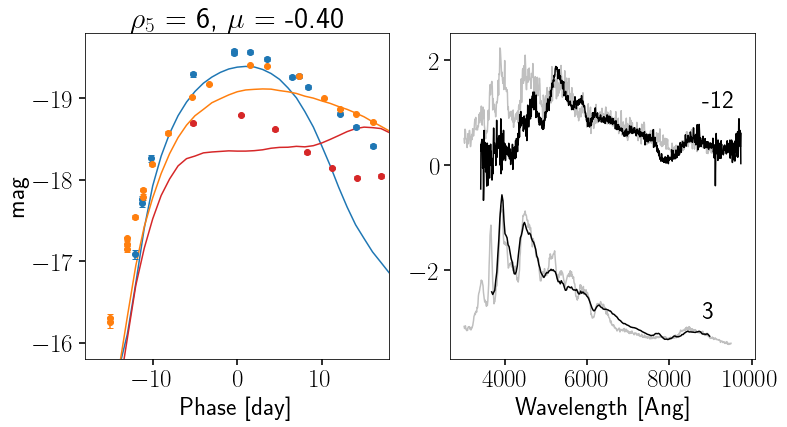

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


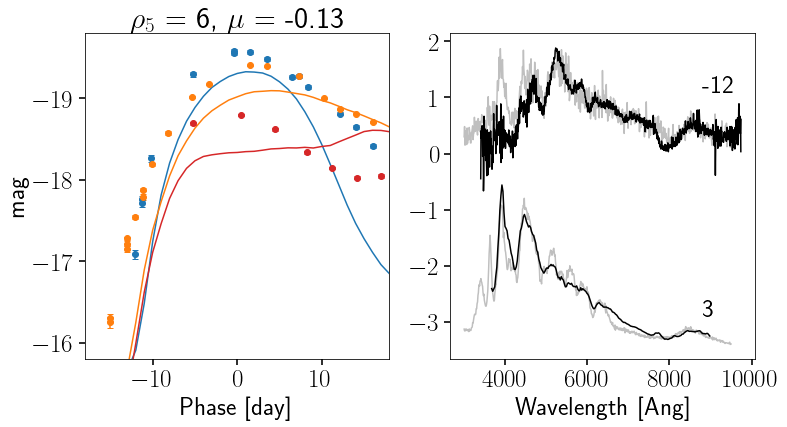

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


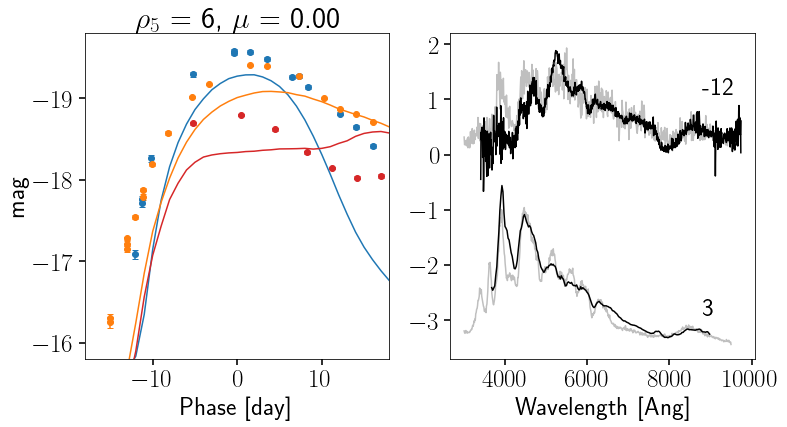

In [21]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_[3-9]e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6, 7]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [15]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    # if (m_tot != 1.0) or (rho != 6): continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    for i in [0, 2, 4, 6, 8, 10, 12, 14]:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        np.savetxt(
            "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_lc.txt".format(m_tot, rho, cos_theta[i] * 100),
            np.array([time[ind], fit_g, fit_r, fit_i, fit_B, fit_B_0]).T,
            fmt="%.2f %.3f %.3f %.3f %.3f %.3f",
            header="Time ZTFg ZTFr ZTFi B B(unreddened)",
        )
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        phase_idx = np.argmin(np.abs(time - t_max))
        idx_wv = (wv0 > 3000) & (wv0 < 10000)
        np.savetxt(
            "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_spec.txt".format(
                m_tot, rho, cos_theta[i] * 100
            ),
            np.array(
                [
                    wv,
                    Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

1.0 14.0


/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.75
15.75
15.75
15.25
14.75
14.25
13.75
12.75
1.0 6.0
16.75
16.75
16.25
15.25
14.75
14.25
13.75
12.75
1.1 3.0
17.25
16.25
17.25
17.75
17.25
15.25
14.75
13.75


In [24]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 11) & (time < 23)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    # if m_tot == 1 and rho == '6':
    #     i_range = [2, 4, 6]
    # else:
    #     i_range = [0, 2, 4]
    i_range = [2, 7]
    for i in i_range:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        phases = [-13, -12, -11, 0, 1, 2, 3]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 10000)

            np.savetxt(
                "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_phase_{:.0f}_spec.txt".format(
                    m_tot, rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv,
                        Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx]),
            )

        phases = [-12.1, 0, 2.52]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            log_Lsun = np.log10(
                trapz(
                    (Flam[i][phase_idx] / (E_Gal * E_Host))[idx_wv],
                    wv0[idx_wv],
                )
                * (4 * np.pi * (10 * u.pc).to("cm").value ** 2)
                * (1 + z)
                / 3.828e33  # Lsun in cgs
            )
            np.savetxt(
                "../TARDIS/Shen+2021/d{}e5_mu_{:.0f}_phase_{:.1f}_spec.txt".format(
                    rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv0,
                        Flam[i][phase_idx]
                        / (E_Gal * E_Host)
                        * (1 + z)
                        * (10e-6 / 114.48) ** 2,  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx])
                + "log_Lsun = {:.2f}".format(log_Lsun),
            )

1.0 14.0
14.75
1.0 6.0
14.75
1.1 3.0
15.75


## Modeling the silicon features

In [13]:
sys.path.append('../spectroscopy')

from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736 #redshift
synth_spec = [f for f in sorted(glob.glob('./Shen+21_model/*mu*spec*')) if not 'phase' in f]
synth_lc = sorted(glob.glob('./Shen+21_model/*mu*lc*'))

def lambda_rf(lambda_0, vel):
    c = 2.99792458e5
    beta = vel / c
    lambda_rf = np.sqrt((1 + beta) / (1 - beta)) * lambda_0
    return lambda_rf

1.0 1400000.0 -13.0
assign manual snr...
LS estimation:
Velocity 1: -10606 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10720.941  178.251 -10894.776 -10538.782      2.822    1.996   
v_sig[0]    2552.282  193.839   2333.585   2707.481      3.434    2.448   
A[0]        -803.392   62.944   -867.523   -746.398      1.193    0.846   
sigma_0        0.072    0.004      0.067      0.075      0.000    0.000   
EW_0          36.392    2.669     33.863     38.989      0.050    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4017.936  2944.832  1.002  
v_sig[0]   3228.913  3024.813  1.000  
A[0]       2780.567  2878.012  1.000  
sigma_0    3985.615  2787.318  1.000  
EW_0       2828.796  2946.168  1.000  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11078.784  264.216 -11311.615 -10786.767      4.317    3.052   
v_sig[0]    2374.230  254.674   2232.263   2769.546      4.619    3.277   
A[0]        -507.430   76.092   -585.072   -432.695      1.472    1.041   
sigma_0        0.092    0.005      0.086      0.097      0.000    0.000   
EW_0          16.223    2.331     14.123     18.805      0.045    0.032   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3747.193  3335.676  1.000  
v_sig[0]   2831.452  2600.637  1.001  
A[0]       2664.490  2836.102  1.001  
sigma_0    4229.554  2611.739  1.006  
EW_0       2680.080  2789.985  1.001  


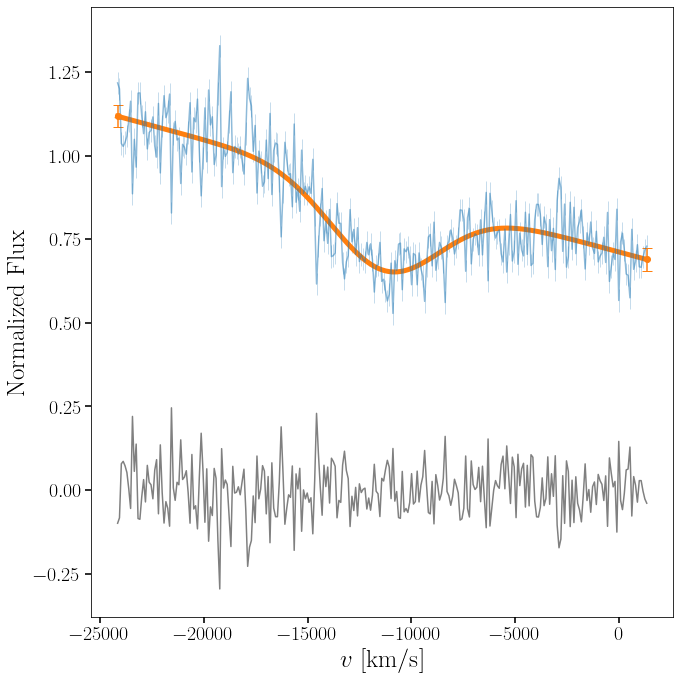

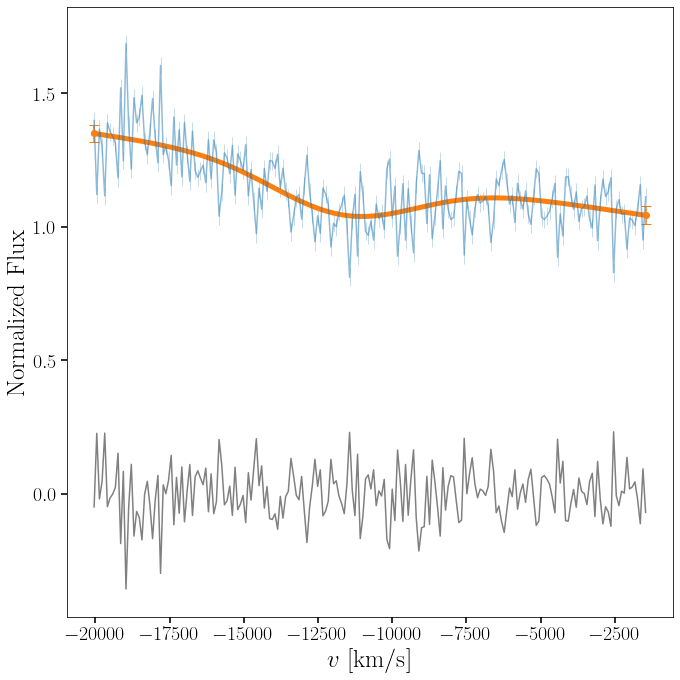

1.0 1400000.0 -40.0
assign manual snr...
LS estimation:
Velocity 1: -10586 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10727.144  158.439 -10877.610 -10571.316      2.472    1.748   
v_sig[0]    2575.404  177.312   2377.005   2724.846      3.072    2.178   
A[0]        -745.218   55.223   -798.740   -691.083      0.981    0.697   
sigma_0        0.059    0.003      0.056      0.062      0.000    0.000   
EW_0          35.223    2.446     32.795     37.603      0.043    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4114.217  3175.298  1.000  
v_sig[0]   3341.548  3009.350  1.002  
A[0]       3186.215  2713.554  1.000  
sigma_0    4585.713  2726.418  1.002  
EW_0       3241.024  2736.566  1.000  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11132.388  353.944 -11462.918 -10759.405      5.791    4.104   
v_sig[0]    2623.611  166.922   2585.729   2814.822      2.671    1.889   
A[0]        -390.144   58.926   -451.118   -332.744      1.052    0.744   
sigma_0        0.073    0.004      0.068      0.077      0.000    0.000   
EW_0          13.127    1.917     11.347     15.196      0.034    0.024   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3733.481  2915.409  1.001  
v_sig[0]   3572.110  2341.608  1.001  
A[0]       3139.104  2622.849  1.000  
sigma_0    5213.283  3040.542  1.000  
EW_0       3152.270  2730.445  1.000  


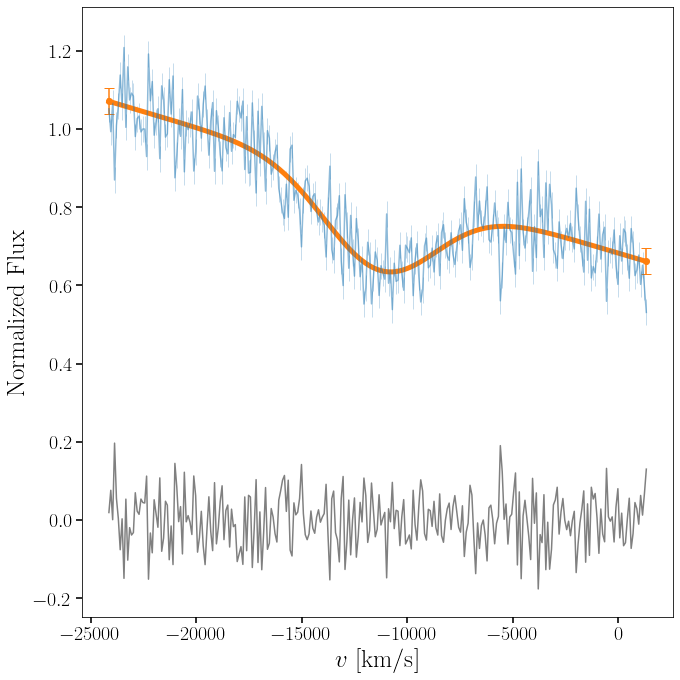

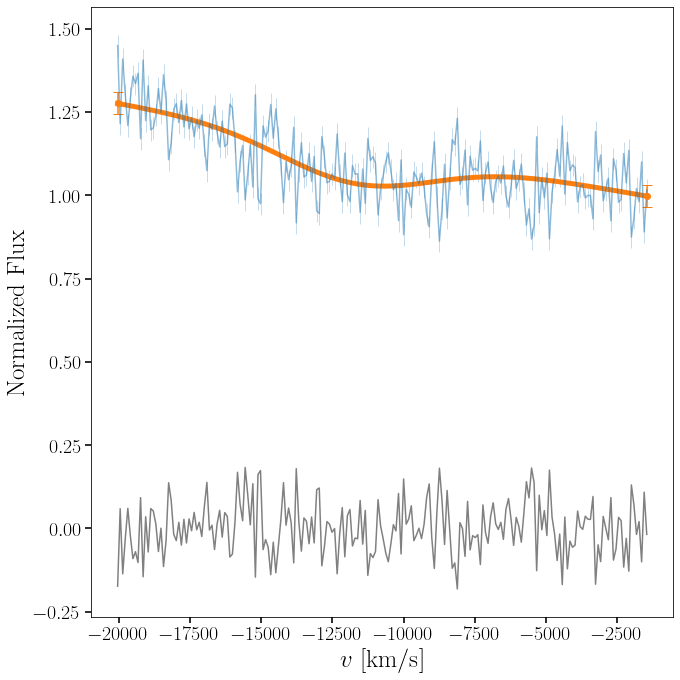

1.0 1400000.0 -67.0
assign manual snr...
LS estimation:
Velocity 1: -10674 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10749.719  187.093 -10943.656 -10571.300      2.915    2.062   
v_sig[0]    2510.622  213.188   2298.744   2710.016      3.916    2.769   
A[0]        -636.659   54.697   -691.338   -584.376      1.012    0.716   
sigma_0        0.058    0.003      0.054      0.061      0.000    0.000   
EW_0          30.414    2.470     28.094     32.917      0.045    0.032   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4119.645  3079.073  1.000  
v_sig[0]   2950.562  2728.580  1.002  
A[0]       2919.792  2563.287  1.003  
sigma_0    3975.971  2661.130  1.001  
EW_0       2967.050  2615.975  1.003  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11855.331  354.023 -12251.482 -11543.840      5.946    4.205   
v_sig[0]    2523.088  184.918   2476.449   2739.716      2.985    2.111   
A[0]        -400.280   66.734   -467.845   -335.978      1.238    0.875   
sigma_0        0.079    0.005      0.074      0.083      0.000    0.000   
EW_0          13.378    2.153     11.460     15.711      0.040    0.028   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3553.688  3344.061  1.000  
v_sig[0]   3646.618  2597.909  1.001  
A[0]       2908.755  2664.369  1.001  
sigma_0    4524.527  2890.269  1.003  
EW_0       2920.604  2762.644  1.001  


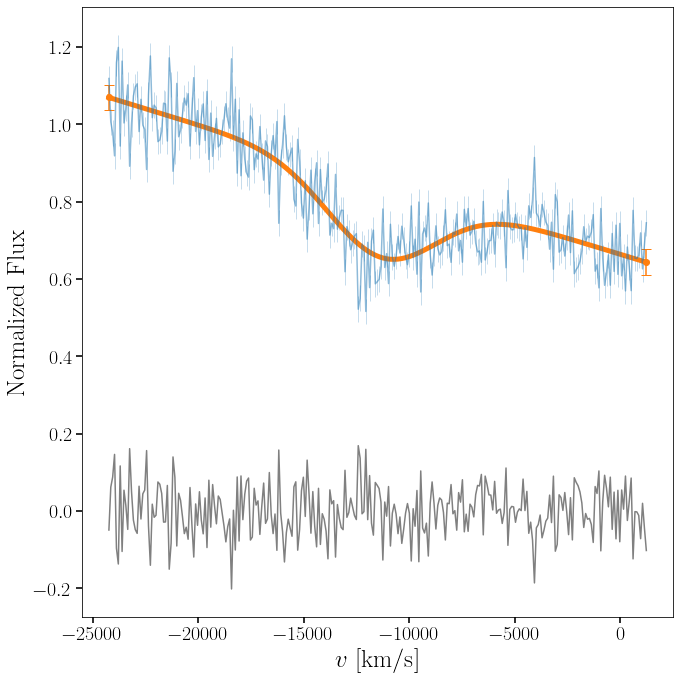

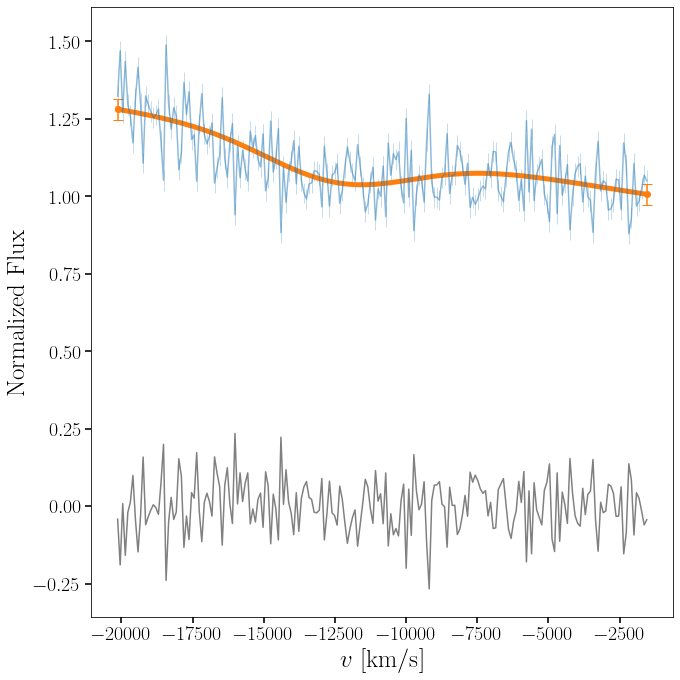

1.0 1400000.0 -93.0
assign manual snr...
LS estimation:
Velocity 1: -11210 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11180.571  266.376 -11455.374 -10929.857      4.629    3.274   
v_sig[0]    2526.302  305.959   2239.757   2842.200      6.283    4.444   
A[0]        -505.971   60.404   -557.556   -438.883      1.204    0.854   
sigma_0        0.063    0.003      0.060      0.067      0.000    0.000   
EW_0          24.687    2.809     21.456     27.028      0.056    0.040   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3352.073  2766.336  1.000  
v_sig[0]   2361.178  2888.470  1.000  
A[0]       2533.728  2870.582  1.001  
sigma_0    3372.794  2459.190  1.002  
EW_0       2555.878  2986.049  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11346.935  548.513 -11935.384 -10860.987     11.194    8.031   
v_sig[0]    2302.199  280.463   2142.472   2746.032      4.567    3.230   
A[0]         -40.033   32.525    -49.287     -0.004      0.697    0.493   
sigma_0        0.083    0.005      0.077      0.086      0.000    0.000   
EW_0           1.392    1.126      0.000      1.715      0.024    0.017   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2409.071  1799.260  1.001  
v_sig[0]   3522.801  2261.449  1.001  
A[0]       1846.776  1531.662  1.003  
sigma_0    3414.793  2621.846  1.002  
EW_0       1850.266  1537.928  1.003  


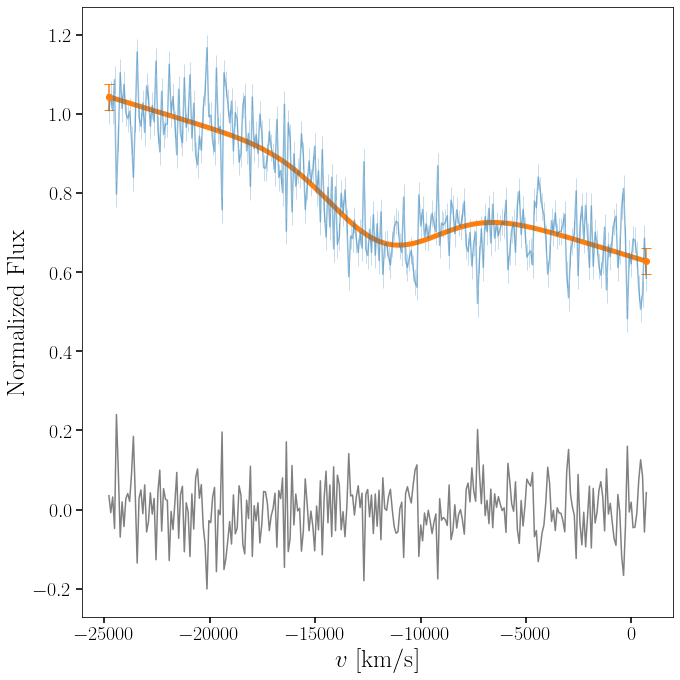

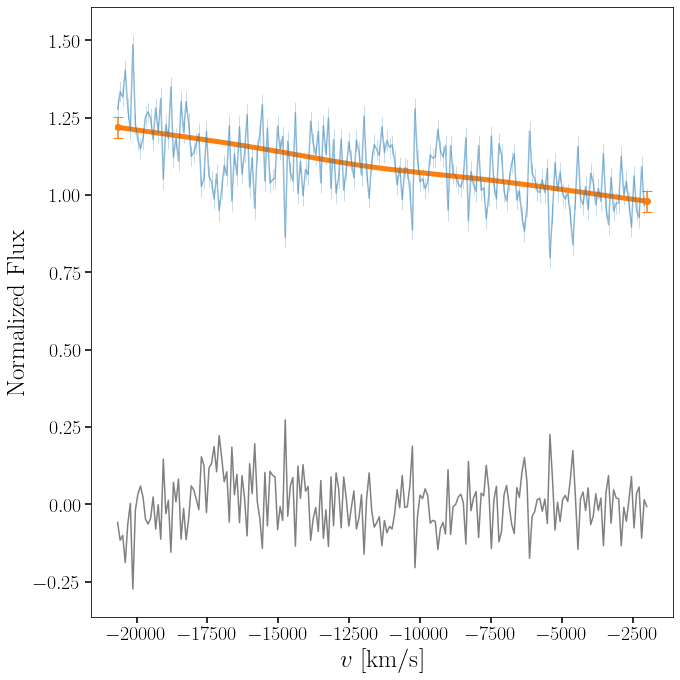

1.0 1400000.0 13.0
assign manual snr...
LS estimation:
Velocity 1: -11228 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11438.434  171.223 -11599.978 -11260.224      2.729    1.931   
v_sig[0]    2836.979  197.792   2634.389   3020.698      3.771    2.667   
A[0]        -962.009   70.668  -1032.273   -893.629      1.454    1.028   
sigma_0        0.071    0.004      0.067      0.074      0.000    0.000   
EW_0          40.313    2.748     37.437     42.851      0.056    0.040   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3931.225  2866.827  1.000  
v_sig[0]   2757.755  2674.323  1.000  
A[0]       2358.875  2866.590  1.000  
sigma_0    4398.636  2679.782  1.001  
EW_0       2392.517  2781.174  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10643.152  211.599 -10868.279 -10444.116      3.414    2.415   
v_sig[0]    2379.965  231.993   2038.120   2500.156      4.378    3.108   
A[0]        -653.008   75.000   -720.802   -573.188      1.537    1.097   
sigma_0        0.088    0.005      0.083      0.092      0.000    0.000   
EW_0          19.473    2.122     17.219     21.387      0.043    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3842.492  2824.394  1.000  
v_sig[0]   2774.527  2509.508  1.001  
A[0]       2422.712  2638.562  1.000  
sigma_0    4288.424  2817.405  1.001  
EW_0       2447.117  2713.678  1.000  


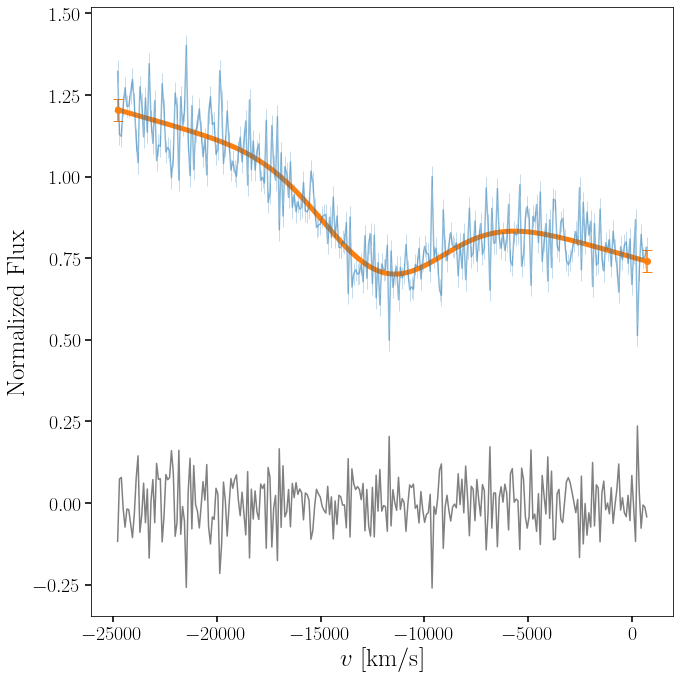

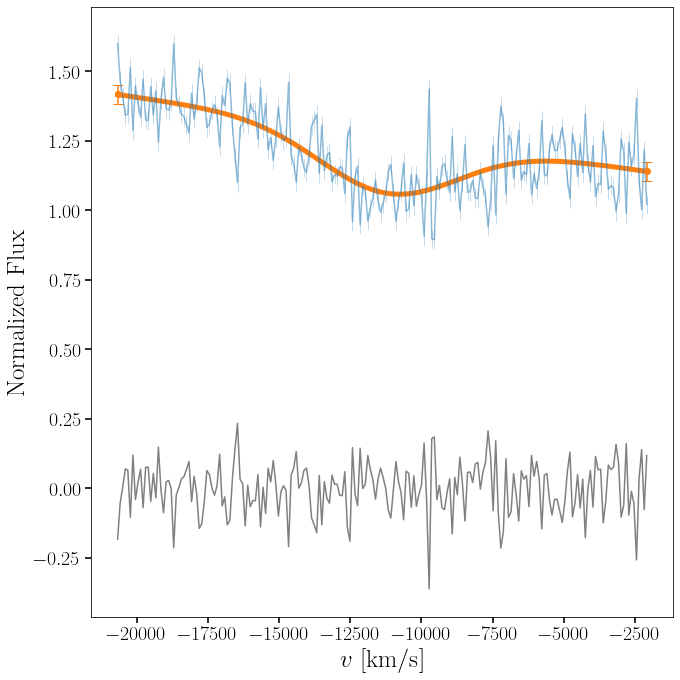

1.0 1400000.0 40.0
assign manual snr...
LS estimation:
Velocity 1: -11136 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11230.562  167.165 -11401.203 -11073.035      2.607    1.845   
v_sig[0]    2820.644  193.254   2624.207   2999.547      3.397    2.419   
A[0]       -1101.398   79.152  -1175.096  -1019.184      1.495    1.061   
sigma_0        0.081    0.004      0.076      0.085      0.000    0.000   
EW_0          42.622    2.828     39.589     45.150      0.053    0.038   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4116.197  2762.011  1.001  
v_sig[0]   3278.500  2756.465  1.000  
A[0]       2809.979  2441.365  1.000  
sigma_0    4452.948  2661.541  1.003  
EW_0       2821.499  2483.601  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11586.740  223.532 -11832.560 -11382.195      3.503    2.477   
v_sig[0]    2164.658  154.915   1990.227   2199.056      2.718    1.936   
A[0]        -614.429   66.558   -670.082   -539.501      1.233    0.888   
sigma_0        0.109    0.006      0.103      0.114      0.000    0.000   
EW_0          17.117    1.775     15.313     18.807      0.033    0.023   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4062.037  2858.236  1.001  
v_sig[0]   2952.089  2004.467  1.001  
A[0]       2976.066  2751.641  1.001  
sigma_0    4531.949  2609.364  1.000  
EW_0       3022.548  2630.911  1.000  


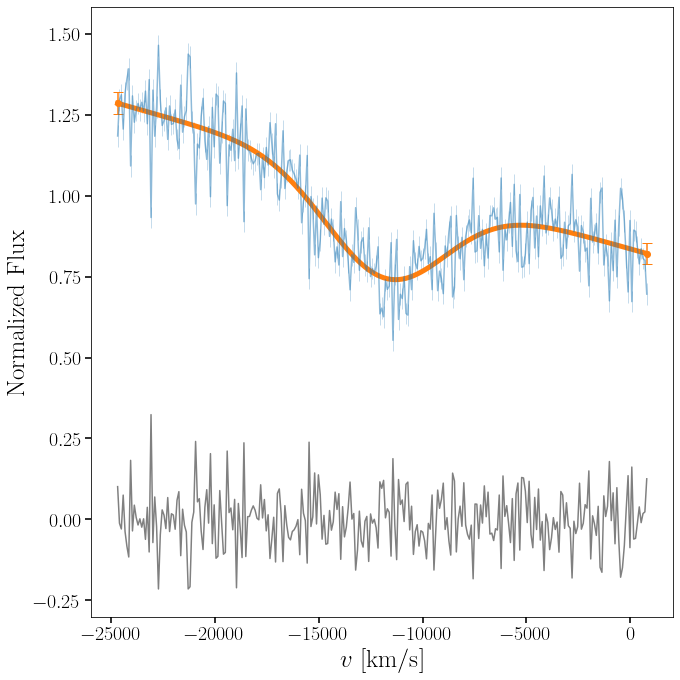

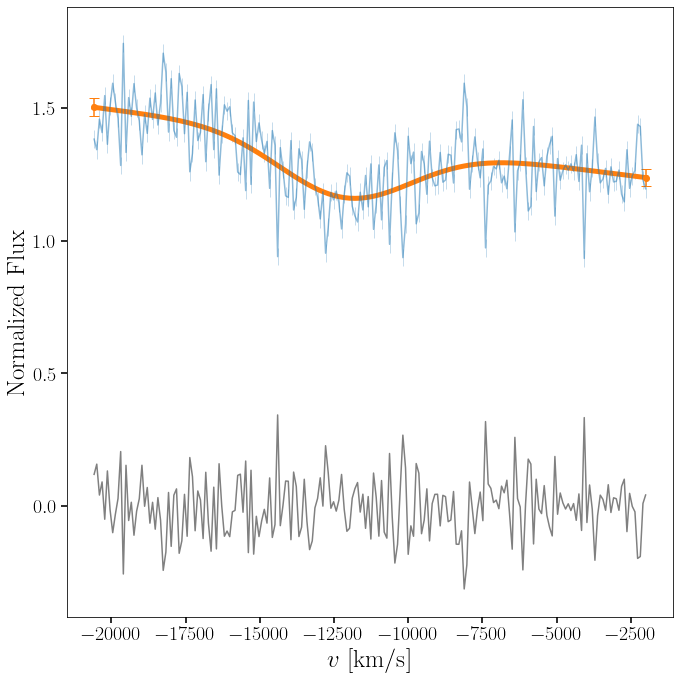

1.0 1400000.0 67.0
assign manual snr...
LS estimation:
Velocity 1: -12218 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12284.147  180.348 -12470.487 -12113.569      2.942    2.080   
v_sig[0]    2906.545  199.203   2686.143   3074.004      3.700    2.630   
A[0]       -1286.866   94.955  -1382.554  -1195.751      1.919    1.360   
sigma_0        0.101    0.005      0.096      0.106      0.000    0.000   
EW_0          42.525    2.906     39.264     44.992      0.058    0.041   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3765.646  2809.233  1.000  
v_sig[0]   2923.270  2863.786  1.002  
A[0]       2460.243  2786.117  1.001  
sigma_0    4241.501  2678.836  1.001  
EW_0       2499.806  2678.161  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12020.124  321.396 -12362.322 -11734.007      5.106    3.611   
v_sig[0]    2394.612  266.761   2050.776   2482.720      4.544    3.265   
A[0]        -501.999   87.026   -574.357   -404.523      1.560    1.146   
sigma_0        0.131    0.007      0.123      0.137      0.000    0.000   
EW_0          12.220    2.057      9.965     13.986      0.036    0.027   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3967.728  2791.475  1.001  
v_sig[0]   3372.080  2558.626  1.000  
A[0]       3173.254  2419.809  1.001  
sigma_0    4102.184  2751.878  1.000  
EW_0       3258.045  2362.840  1.001  


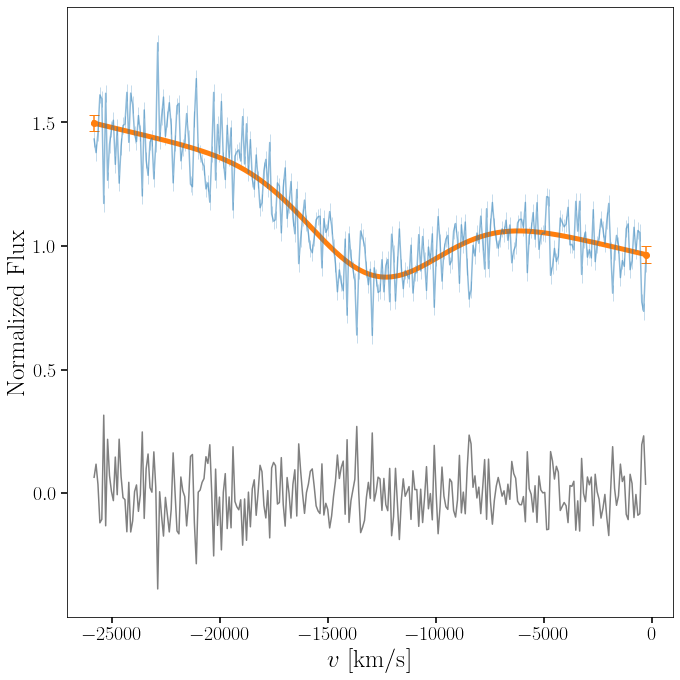

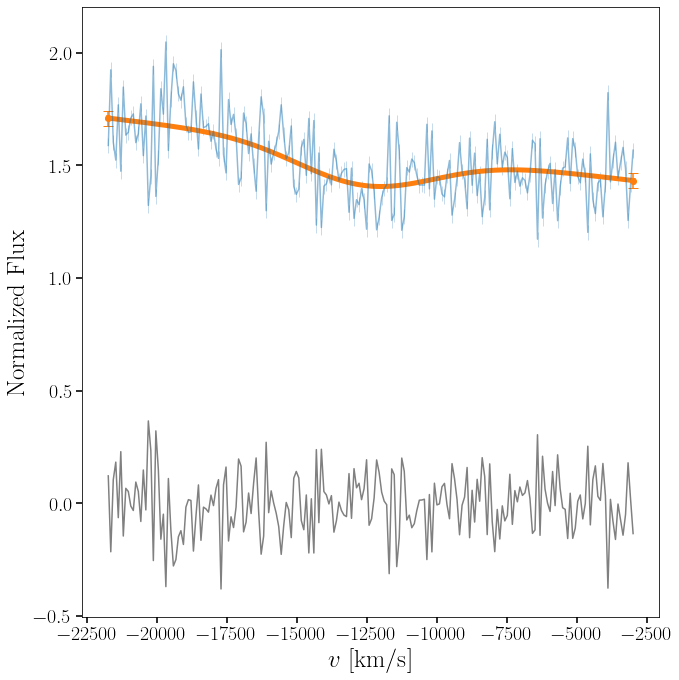

1.0 1400000.0 93.0
assign manual snr...
LS estimation:
Velocity 1: -13189 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13173.666  222.852 -13388.851 -12956.463      3.350    2.371   
v_sig[0]    3502.742  232.358   3266.652   3719.979      4.370    3.105   
A[0]       -2083.147  158.764  -2232.965  -1921.434      3.149    2.247   
sigma_0        0.157    0.007      0.150      0.163      0.000    0.000   
EW_0          53.271    3.712     49.571     56.871      0.073    0.052   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4421.279  2966.865  1.001  
v_sig[0]   2862.283  2669.560  1.000  
A[0]       2591.487  2708.315  1.002  
sigma_0    4494.216  2650.670  1.003  
EW_0       2619.295  2829.174  1.002  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12862.490  350.376 -13162.936 -12464.332      5.292    3.743   
v_sig[0]    2838.390  285.453   2471.291   2928.524      4.577    3.282   
A[0]        -722.980  122.558   -834.041   -601.644      2.129    1.506   
sigma_0        0.170    0.009      0.160      0.177      0.000    0.000   
EW_0          13.752    2.260     11.522     15.805      0.039    0.028   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4389.230  3197.808  1.001  
v_sig[0]   3823.543  2786.630  1.001  
A[0]       3359.661  2375.323  1.002  
sigma_0    4576.981  3070.905  1.000  
EW_0       3377.166  2414.717  1.002  


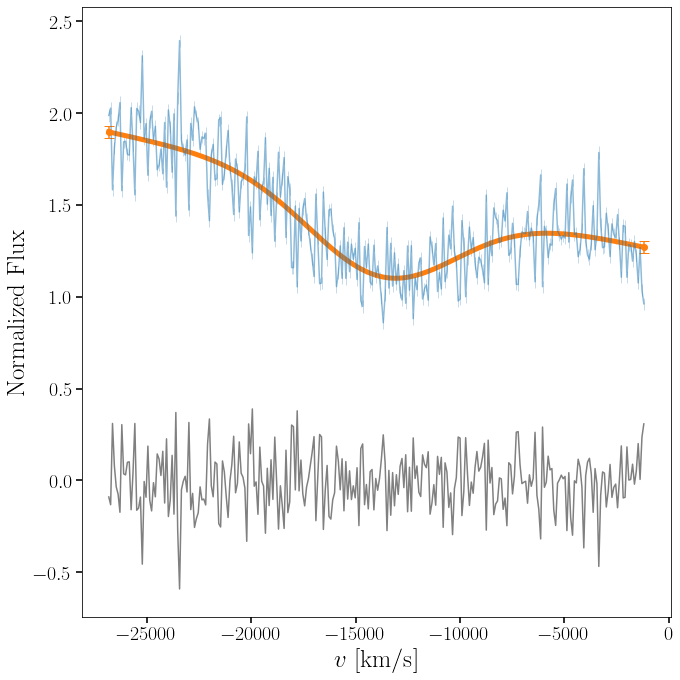

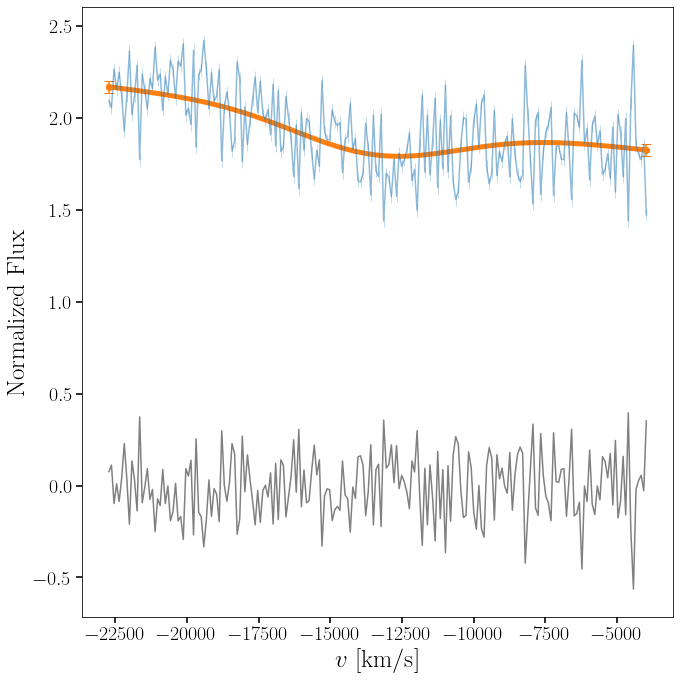

1.0 600000.0 -13.0
assign manual snr...
LS estimation:
Velocity 1: -11002 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11084.869  122.539 -11203.684 -10967.873      1.924    1.361   
v_sig[0]    2767.618  142.605   2617.084   2898.489      2.617    1.860   
A[0]       -1290.994   69.676  -1352.317  -1215.102      1.328    0.941   
sigma_0        0.071    0.004      0.067      0.074      0.000    0.000   
EW_0          55.453    2.702     52.560     57.853      0.051    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4064.751  2862.971  1.001  
v_sig[0]   3015.849  2911.274  1.001  
A[0]       2765.382  2580.966  1.001  
sigma_0    4592.668  3042.528  1.000  
EW_0       2856.132  2700.750  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10970.366  202.248 -11175.280 -10773.903      3.230    2.284   
v_sig[0]    2378.529  226.992   2098.646   2555.309      4.846    3.427   
A[0]        -692.457   75.749   -756.690   -610.079      1.660    1.177   
sigma_0        0.086    0.005      0.080      0.090      0.000    0.000   
EW_0          21.511    2.224     19.135     23.457      0.049    0.034   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3919.046  2606.814  1.000  
v_sig[0]   2063.754  1787.391  1.001  
A[0]       2104.269  2493.687  1.001  
sigma_0    4460.694  2872.078  1.004  
EW_0       2115.119  2528.387  1.001  


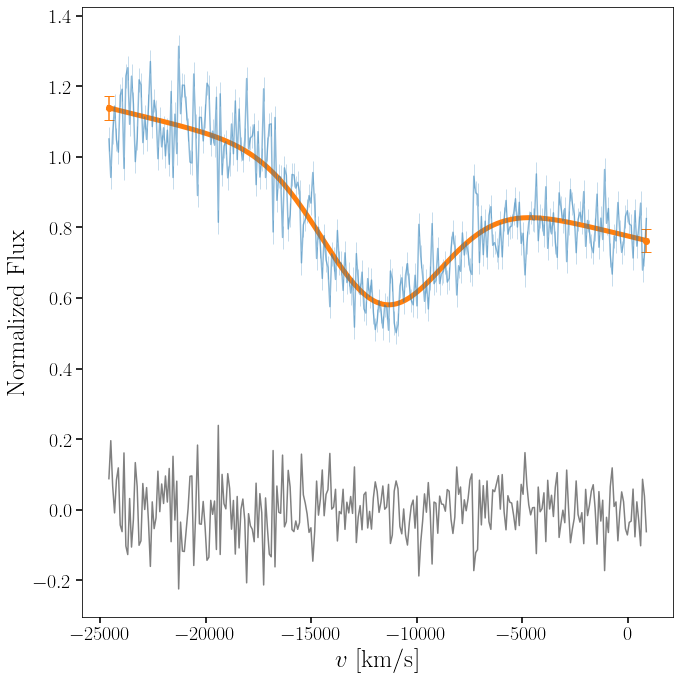

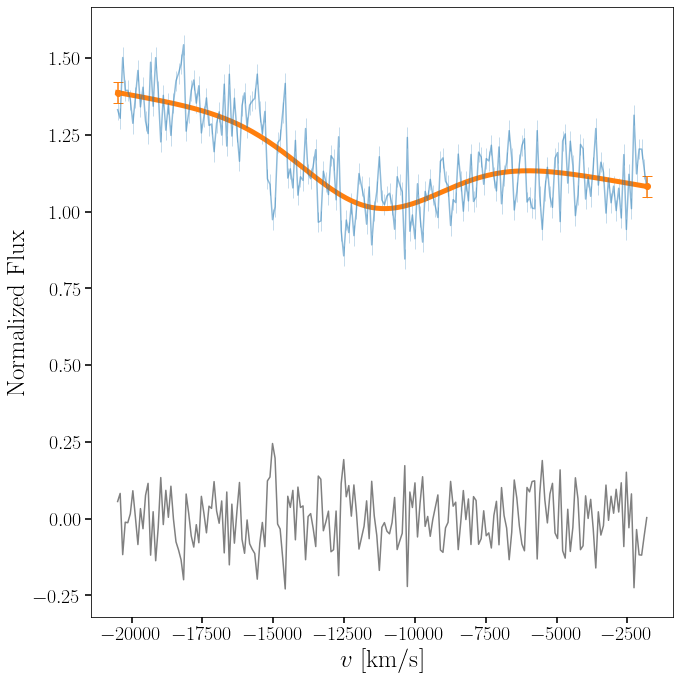

1.0 600000.0 -40.0
assign manual snr...
LS estimation:
Velocity 1: -10835 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10908.233   88.891 -11002.584 -10827.269      1.368    0.968   
v_sig[0]    2549.746  106.216   2449.874   2658.852      1.931    1.368   
A[0]       -1201.036   50.628  -1249.691  -1151.592      0.920    0.650   
sigma_0        0.053    0.003      0.050      0.056      0.000    0.000   
EW_0          53.255    2.037     51.024     55.009      0.037    0.026   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4232.056  2989.662  1.001  
v_sig[0]   3025.391  2970.221  1.002  
A[0]       3019.599  2989.056  1.002  
sigma_0    4443.881  2635.599  1.001  
EW_0       3090.245  3071.896  1.002  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.6513, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11156.517  146.340 -11294.383 -11009.422      2.382    1.684   
v_sig[0]    1994.478  136.455   1802.192   2039.663      2.541    1.803   
A[0]        -630.384   52.114   -672.024   -571.278      0.975    0.698   
sigma_0        0.073    0.004      0.068      0.077      0.000    0.000   
EW_0          20.189    1.582     18.285     21.364      0.029    0.021   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3801.695  2919.175  1.002  
v_sig[0]   2725.616  2150.921  1.003  
A[0]       2929.599  2458.303  1.001  
sigma_0    3920.785  2568.532  1.000  
EW_0       2954.464  2474.429  1.001  


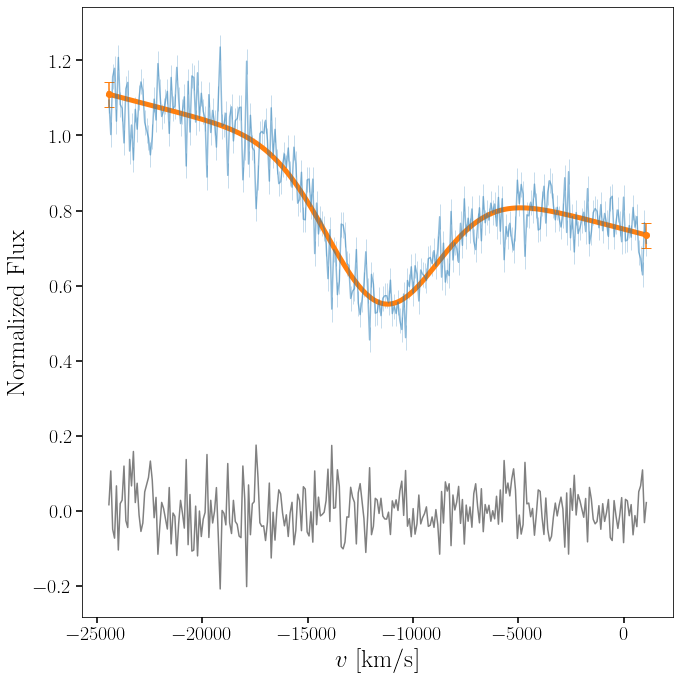

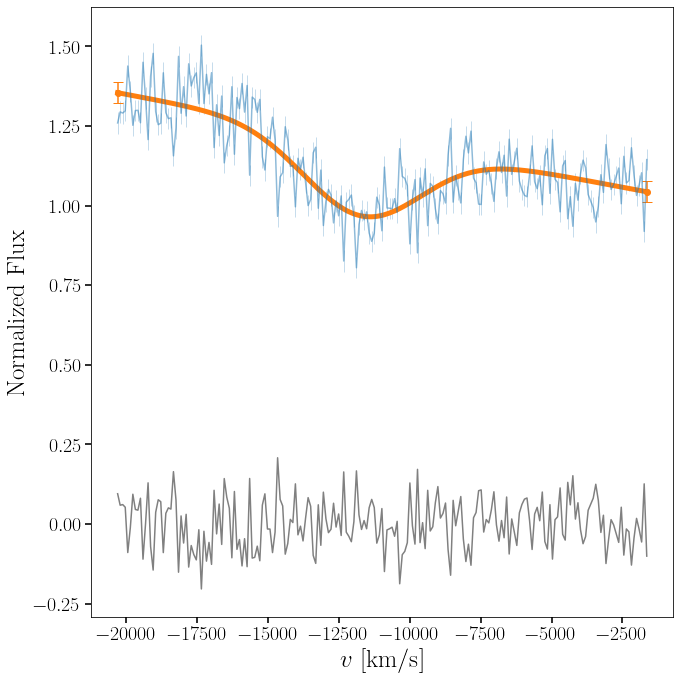

1.0 600000.0 -67.0
assign manual snr...
LS estimation:
Velocity 1: -10600 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10764.975  119.878 -10877.792 -10641.403      1.787    1.264   
v_sig[0]    2755.984  140.075   2612.017   2886.146      2.717    1.922   
A[0]       -1095.285   58.580  -1148.640  -1032.508      1.167    0.827   
sigma_0        0.057    0.003      0.053      0.060      0.000    0.000   
EW_0          50.050    2.439     47.642     52.481      0.048    0.034   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4516.925  2967.954  1.002  
v_sig[0]   2641.975  2593.066  1.001  
A[0]       2532.403  2475.649  1.002  
sigma_0    4401.412  2735.110  1.001  
EW_0       2614.373  2831.713  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11162.217  199.328 -11351.817 -10962.523      3.443    2.435   
v_sig[0]    2651.157  207.390   2501.161   2929.547      4.657    3.310   
A[0]        -779.489   80.242   -864.057   -700.916      1.832    1.307   
sigma_0        0.074    0.004      0.069      0.078      0.000    0.000   
EW_0          25.123    2.418     22.658     27.568      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3336.216  2916.870  1.000  
v_sig[0]   1811.648  1639.296  1.000  
A[0]       1939.836  2585.312  1.000  
sigma_0    4403.411  2532.149  0.999  
EW_0       1967.580  2650.160  1.000  


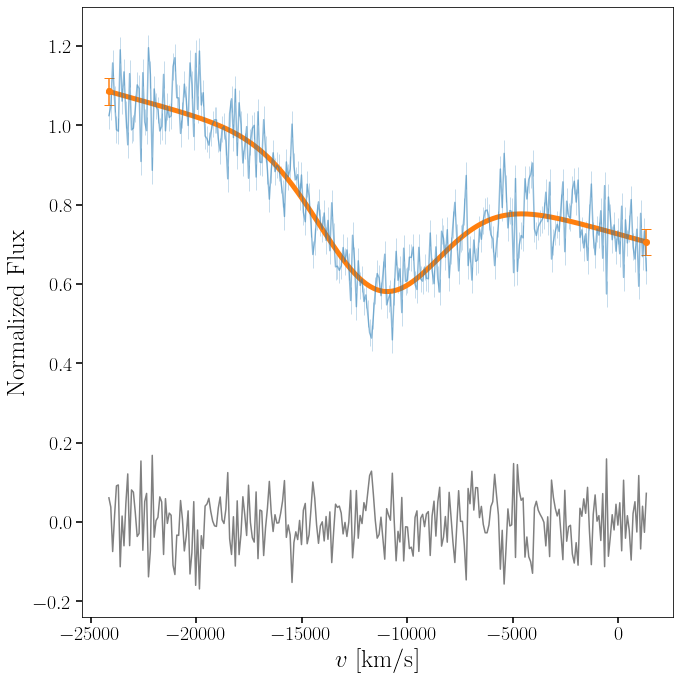

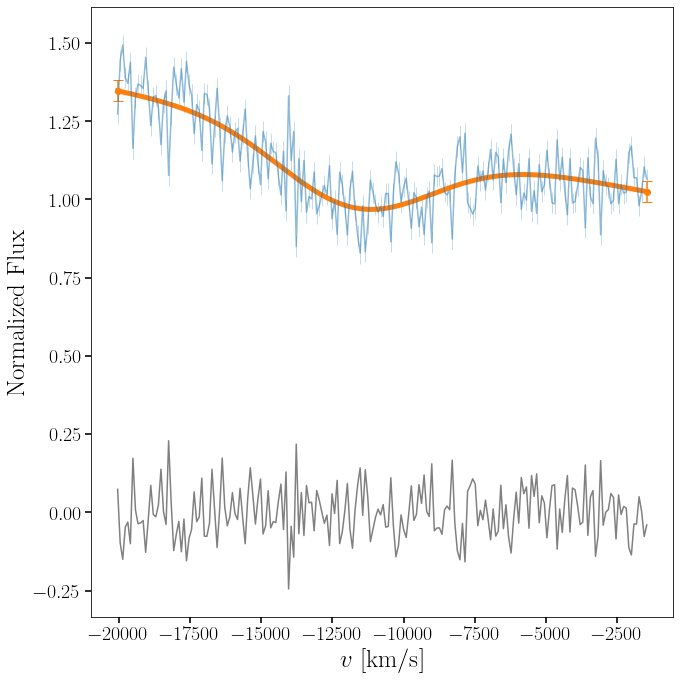

1.0 600000.0 -93.0
assign manual snr...
LS estimation:
Velocity 1: -11038 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11105.565  126.880 -11223.775 -10975.446      1.955    1.382   
v_sig[0]    2921.679  159.102   2748.538   3067.148      3.121    2.210   
A[0]        -959.948   55.110  -1016.038   -908.237      1.118    0.793   
sigma_0        0.045    0.003      0.042      0.048      0.000    0.000   
EW_0          47.145    2.473     44.685     49.526      0.050    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4221.717  2913.866  1.002  
v_sig[0]   2599.970  2882.394  1.001  
A[0]       2444.366  2521.320  1.002  
sigma_0    4394.927  2728.198  1.002  
EW_0       2486.386  2469.983  1.002  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11927.161  271.868 -12209.924 -11674.976      5.026    3.554   
v_sig[0]    2887.116  220.322   2802.632   3191.815      4.847    3.431   
A[0]        -601.401   72.039   -672.141   -527.350      1.555    1.100   
sigma_0        0.066    0.004      0.062      0.070      0.000    0.000   
EW_0          20.849    2.363     18.557     23.281      0.051    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2920.007  2977.293  1.001  
v_sig[0]   1919.476  2233.960  1.001  
A[0]       2152.595  2459.775  1.001  
sigma_0    4159.008  2937.973  1.000  
EW_0       2170.769  2463.889  1.001  


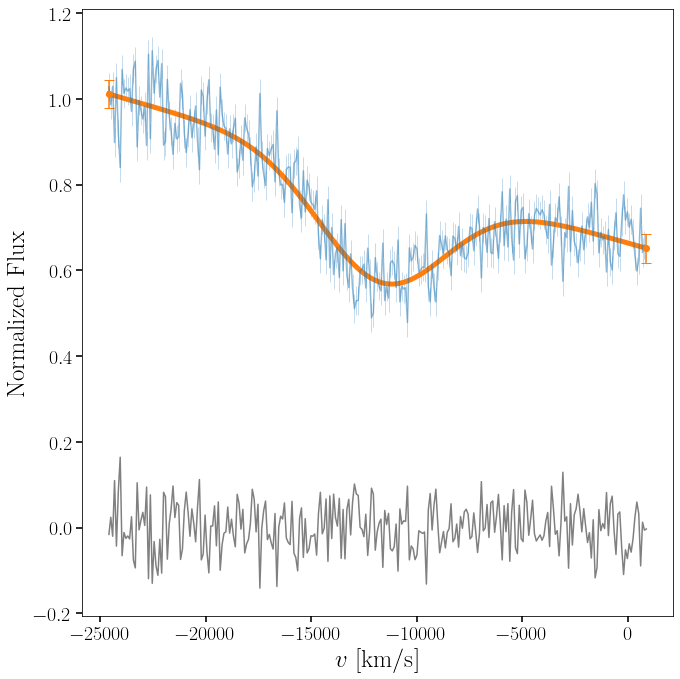

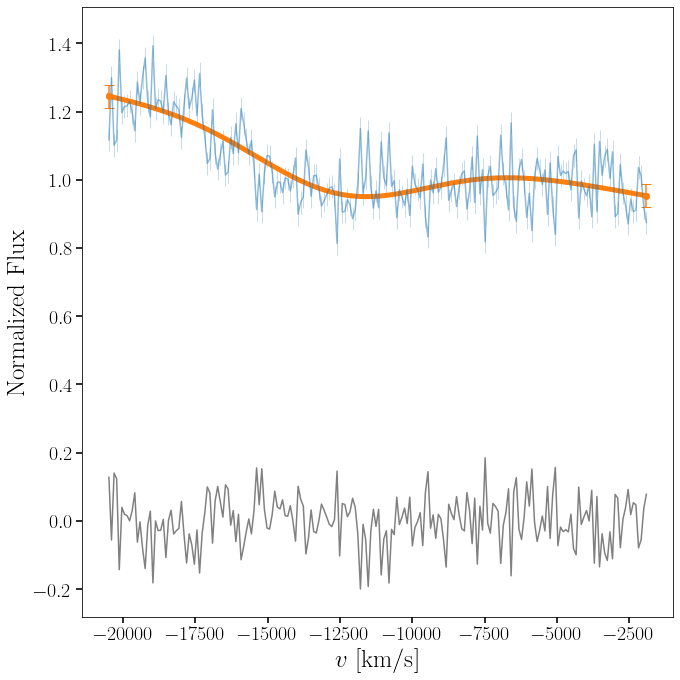

1.0 600000.0 13.0
assign manual snr...
LS estimation:
Velocity 1: -11352 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11486.759  116.177 -11599.007 -11370.986      1.748    1.236   
v_sig[0]    2951.073  133.437   2798.919   3062.943      2.632    1.861   
A[0]       -1632.093   79.086  -1718.718  -1560.884      1.638    1.158   
sigma_0        0.078    0.004      0.074      0.081      0.000    0.000   
EW_0          62.604    2.701     59.931     65.296      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4392.575  3064.128  1.000  
v_sig[0]   2564.114  2736.323  1.001  
A[0]       2316.817  2533.625  1.002  
sigma_0    4534.971  3023.456  1.002  
EW_0       2408.781  2888.205  1.002  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11442.631  191.702 -11608.705 -11231.460      3.156    2.232   
v_sig[0]    2367.561  190.252   2108.470   2453.212      4.188    2.963   
A[0]        -893.913   87.548   -968.943   -801.259      1.877    1.345   
sigma_0        0.106    0.006      0.100      0.112      0.000    0.000   
EW_0          24.625    2.258     22.104     26.461      0.048    0.034   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3702.576  2721.836  1.001  
v_sig[0]   1951.719  1903.217  1.001  
A[0]       2267.176  2041.820  1.001  
sigma_0    3902.450  2726.910  1.001  
EW_0       2274.268  2185.473  1.001  


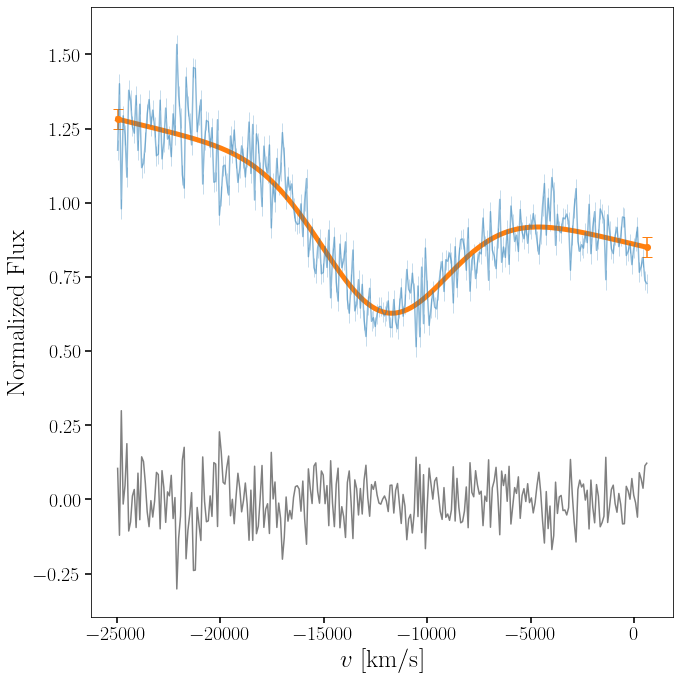

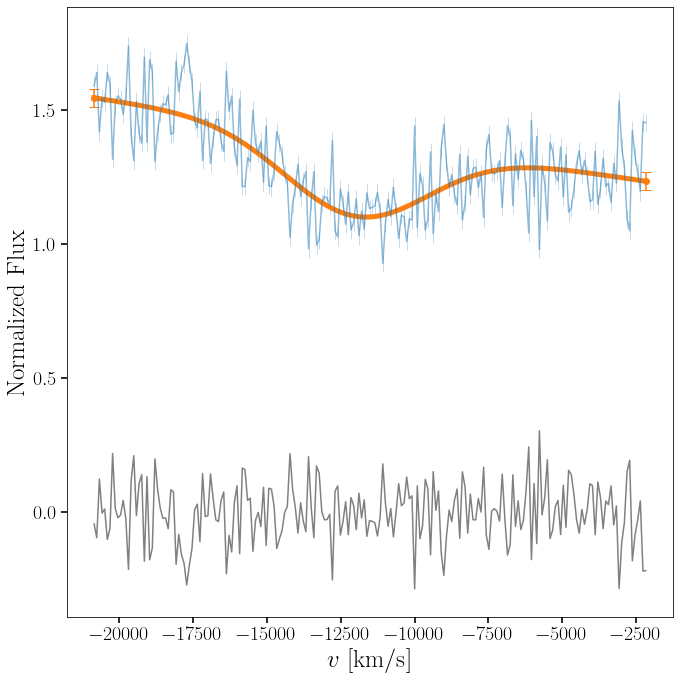

1.0 600000.0 40.0
assign manual snr...
LS estimation:
Velocity 1: -12054 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12075.277  112.822 -12181.913 -11959.840      1.714    1.212   
v_sig[0]    2874.972  119.725   2737.208   2975.627      2.217    1.569   
A[0]       -1827.161   83.055  -1911.516  -1749.377      1.653    1.170   
sigma_0        0.089    0.004      0.085      0.093      0.000    0.000   
EW_0          61.690    2.506     59.374     64.283      0.049    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4341.965  3006.744  1.000  
v_sig[0]   2914.384  2654.592  1.001  
A[0]       2525.221  2719.028  1.001  
sigma_0    4864.103  3070.860  1.001  
EW_0       2569.037  2934.734  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12813.466  182.823 -12989.559 -12626.544      2.751    1.946   
v_sig[0]    2301.496  163.911   2084.800   2349.528      3.113    2.201   
A[0]       -1139.236   98.700  -1224.701  -1032.462      1.898    1.355   
sigma_0        0.141    0.007      0.133      0.148      0.000    0.000   
EW_0          22.735    1.868     20.676     24.348      0.036    0.026   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4408.480  2623.002  1.001  
v_sig[0]   1883.180  1203.009  1.002  
A[0]       2774.574  2690.577  1.002  
sigma_0    4441.628  2535.370  1.000  
EW_0       2783.982  2709.636  1.002  


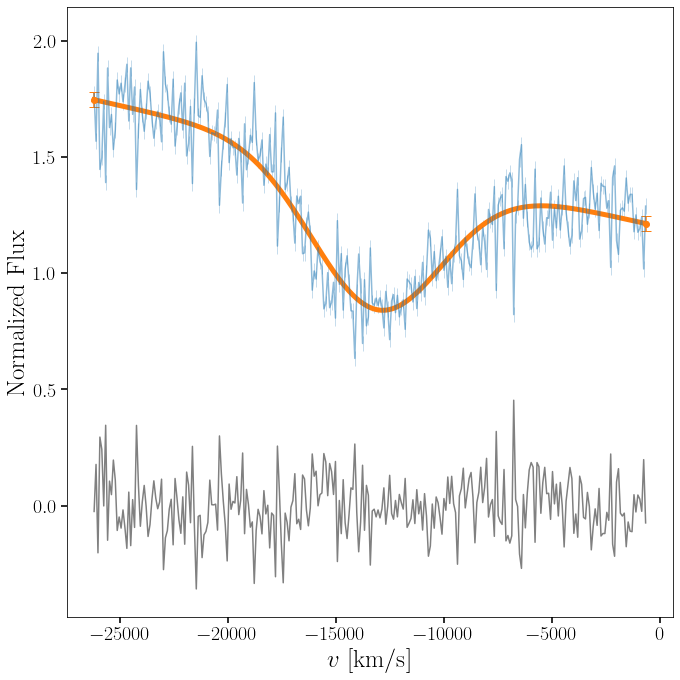

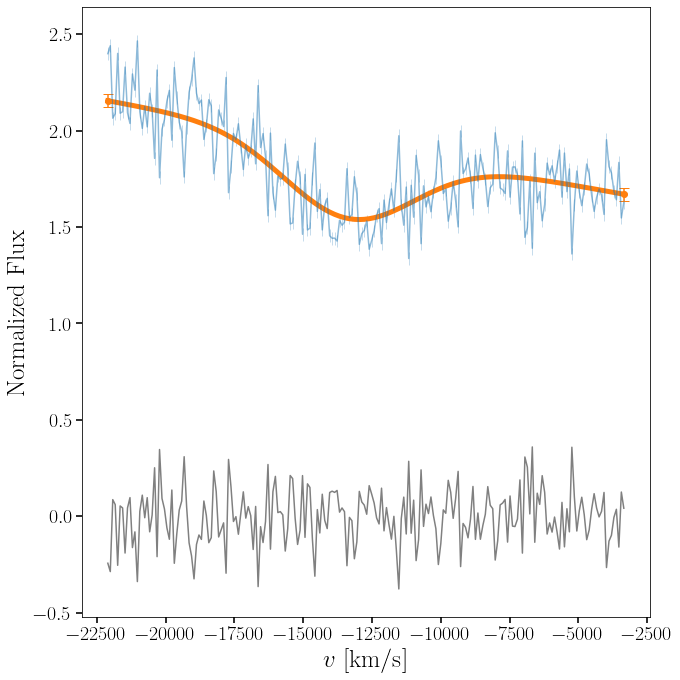

1.0 600000.0 93.0
assign manual snr...
LS estimation:
Velocity 1: -13525 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13483.171  138.037 -13622.533 -13352.719      2.093    1.481   
v_sig[0]    3053.467  151.795   2887.776   3188.217      2.585    1.828   
A[0]       -2890.517  153.400  -3031.176  -2730.914      2.839    2.008   
sigma_0        0.169    0.008      0.162      0.176      0.000    0.000   
EW_0          65.991    3.155     62.531     68.702      0.058    0.041   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4383.123  3066.634  1.003  
v_sig[0]   3441.377  2973.651  1.001  
A[0]       2911.191  2993.570  1.001  
sigma_0    4393.297  2648.337  1.002  
EW_0       3001.972  2947.930  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6813, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -18170.726  525.639 -18671.704 -17638.967     10.605    7.505   
v_sig[0]    2978.700  363.175   2429.358   3172.225      6.068    4.291   
A[0]        -287.489  116.891   -393.334   -157.316      2.787    1.971   
sigma_0        0.151    0.008      0.143      0.159      0.000    0.000   
EW_0           5.668    2.277      3.123      7.723      0.054    0.038   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2458.852  2510.168  1.001  
v_sig[0]   3395.110  2107.637  1.003  
A[0]       1682.174  1347.066  1.001  
sigma_0    2960.759  2449.484  1.000  
EW_0       1693.829  1351.882  1.001  


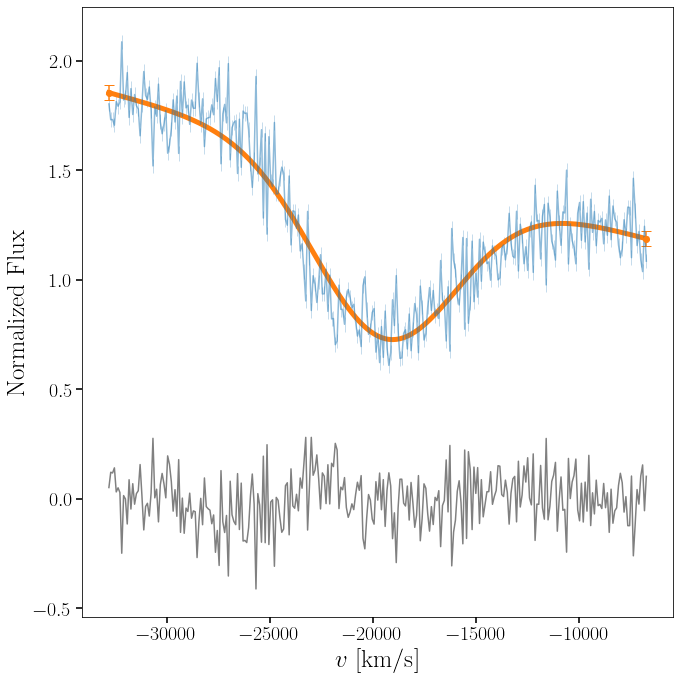

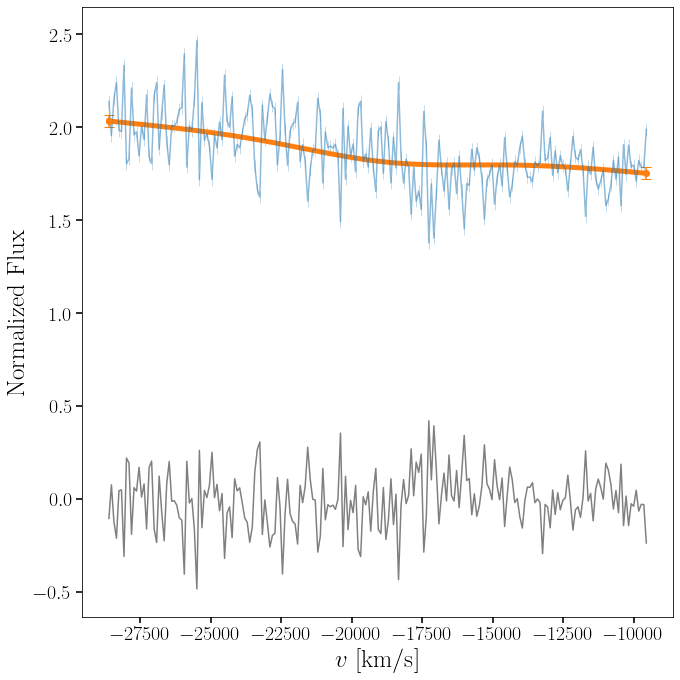

In [14]:
syn_mc = np.empty_like(synth_spec, dtype=float)
syn_rho = np.empty_like(synth_spec, dtype=float)
syn_mu = np.empty_like(synth_spec, dtype=float)
v_Si_Shen = np.empty_like(synth_spec, dtype=float)
v_Si_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_err_Shen = np.empty_like(synth_spec, dtype=float)

for k in range(len(synth_spec)):
    syn_mc[k] = float(synth_spec[k].split('_')[2])
    syn_rho[k] = float(synth_spec[k].split('_')[4])
    syn_mu[k] = float(synth_spec[k].split('_')[6])
    print(syn_mc[k], syn_rho[k], syn_mu[k])
    Spec = SpectrumSN_Lines(synth_spec[k], z, snr=30)
    Spec.add_line("SiII0", 5750, 6450, lines=[6371.359, 6347.103])
    Spec.line["SiII0"].LS_estimator()
    v_temp = Spec.line["SiII0"].theta_LS[2]

    Spec.add_line(
        "SiII_6355",
        lambda_rf(6347.103, v_temp) - 250,
        lambda_rf(6371.359, v_temp) + 250,
        lines=[6371.359, 6347.103],
    )
    print(Spec.snr)
    try:
        Spec.line["SiII_6355"].MCMC_sampler(
            vel_mean_mu=[-1e4],
            vel_mean_sig=[3e3],
            initial=Spec.line["SiII0"].theta_LS,
            vel_var_lim=[1e4, 1e10],
            A_lim=[-1e6, 0],
        )
    except:
        print(Spec.line["SiII0"].theta_LS)
        break
    v_Si_Shen[k] = Spec.line["SiII_6355"].theta_MCMC[2]

    Spec.add_line(
        "SiII_5972",
        lambda_rf(5957.561, v_temp) - 160,
        lambda_rf(5978.929, v_temp) + 180,
        lines=[5957.561, 5978.929],
    )
    vel_var_6355 = np.exp(Spec.line["SiII_6355"].theta_MCMC[3])
    Spec.line["SiII_5972"].MCMC_sampler(
        vel_mean_mu=[v_Si_Shen[k]],
        vel_mean_sig=[5e2],
        initial=Spec.line["SiII_6355"].theta_MCMC,
        vel_var_lim=[vel_var_6355 / 2, vel_var_6355 * 1.2],
        A_lim=[-1e6, 0],
    )

    EW_Si_6355_Shen[k], EW_Si_5972_Shen[k] = (
        Spec.line["SiII_6355"].EW[0],
        Spec.line["SiII_5972"].EW[0],
    )
    EW_Si_6355_err_Shen[k], EW_Si_5972_err_Shen[k] = (
        Spec.line["SiII_6355"].sig_EW[0],
        Spec.line["SiII_5972"].sig_EW[0],
    )
    # if (
    #     np.abs(
    #         Spec.line["SiII_5972"].theta_MCMC[2] - Spec.line["SiII_6355"].theta_MCMC[2]
    #     )
    #     > 2000
    # ):
    #     EW_Si_5972_Shen[k] = np.nan
    # if np.abs(syn_mu[k]) >= 90:
    #     EW_Si_6355_Shen[k], EW_Si_5972_Shen[k], v_Si_Shen[k] = np.nan, np.nan, np.nan
    plt.show()

In [15]:
M_B_max_Shen = np.empty_like(synth_lc, dtype=float)

for k in range(len(synth_lc)):
    lc = np.loadtxt(synth_lc[k])
    M_B = lc[:, -1]
    M_B_max_Shen[k] = M_B.min()

In [16]:
np.savetxt(
    fname="./Shen+21_model/1.1Msun_spec_para.dat",
    X=np.array(
        [
            syn_mc,
            syn_mu / 100,
            syn_rho,
            M_B_max_Shen,
            v_Si_Shen,
            v_Si_err_Shen,
            EW_Si_5972_Shen,
            EW_Si_5972_err_Shen,
            EW_Si_6355_Shen,
            EW_Si_6355_err_Shen,
        ]
    ).T,
    fmt="%.1f %.2f %.0f %.3f %.3f %.3f %.3f %.3f %.3f %.3f",
    header="m mu density M_B_max v_Si v_Si_err EW_Si_5972 EW_Si_5972_err EW_Si_6355 EW_Si_6355_err",
)

## Model comparison plot

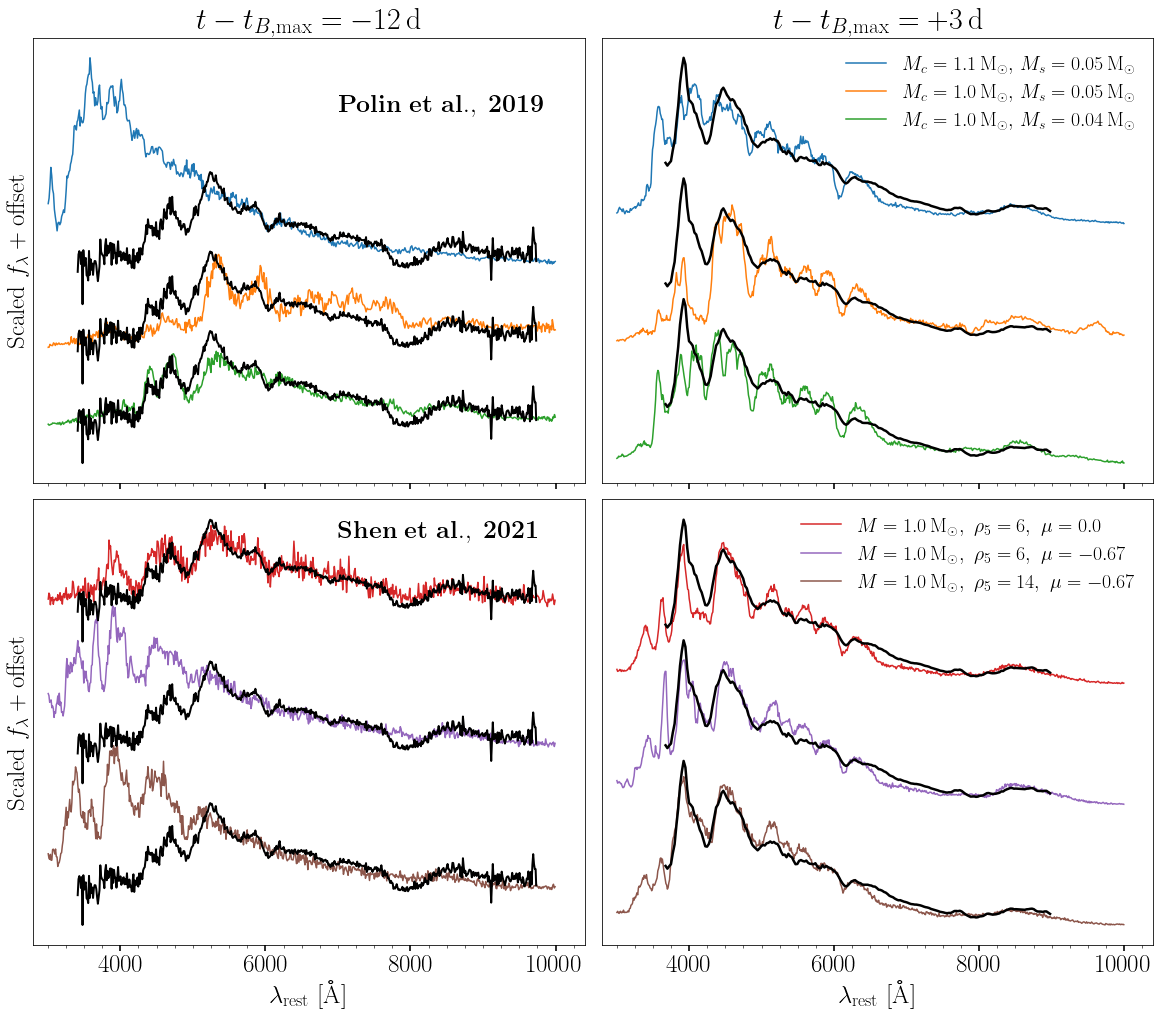

In [18]:
# prop_cycle = plt.rcParams["axes.prop_cycle"]
import seaborn as sns
colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, constrained_layout=True)

h0 = np.array([[1.5, 2.1], [2.9, 2.1]])

# Polin+2019 models
ax = axes[0]
models_Polin = sorted(glob.glob("./Polin+19_model/*1*phase*spec*"), reverse=True)
k = -1
for model in models_Polin:
    mc = float(model.split("_")[2])
    ms = float(model.split("_")[4])
    if (ms >= 0.06) or (ms <= 0.03) or (mc > 1.1):
        continue
    phase = float(model.split("_")[-2])
    if phase == -11:
        a = ax[0]
        h = h0[0, 0]
    elif phase == 2:
        a = ax[1]
        k += 1
        h = h0[0, 1]
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M_c = {mc}\,"
        + r"\mathrm{M_\odot},\,"
        + f"M_s = {ms}\,"
        + r"\mathrm{M_\odot}$",
        color=colors[k],
    )

# Shen+2021 models
ax = axes[1]
models_Shen = sorted(
    glob.glob("./Shen+21_model/*-67*phase*spec*")
    + glob.glob("./Shen+21_model/*6e5*_0_*phase*spec*"),
    reverse=True,
)

k = -1
for model in models_Shen:
    mc = float(model.split("_")[2])
    dens = int(float(model.split("_")[4]) / 1e5)
    phase = float(model.split("_")[-2])
    mu = float(model.split("_")[-4])
    if mc > 1:
        continue
    if phase == -11:
        a = ax[0]
        h = h0[1, 0]
    elif phase == 3:
        a = ax[1]
        h = h0[1, 1]
        k += 1
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M = {mc}\,"
        + r"\mathrm{M_\odot},\ "
        + rf"\rho_5 = {dens},\ \mu = {mu/100}$",
        zorder=int(dens),
        lw=1.5,
        color=colors[k + 3],
    )
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")

axes[0, 1].legend(prop={"size": 20}, frameon=False)
axes[1, 1].legend(prop={"size": 20}, frameon=False)

for i, (a, l) in enumerate(zip(axes[:, 0], [3, 3])):
    spec1_bin = data_binning(spec1, size=10)
    for k in range(l):
        a.plot(
            spec1_bin[:, 0] / (1 + z),
            spec1_bin[:, 1]
            / np.median(spec1[(spec1[:, 0] > 5800) & (spec1[:, 0] < 6500), 1])
            - k * h0[i, 0],
            color="k",
            zorder=100,
            lw=2,
        )
    a.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
for i, (a, l) in enumerate(zip(axes[:, 1], [3, 3])):
    for k in range(l):
        a.plot(
            spec2[:, 0] / (1 + z),
            spec2[:, 1]
            / np.median(spec2[(spec2[:, 0] > 5800) & (spec2[:, 0] < 6500), 1])
            - k * h0[i, 1],
            color="k",
            zorder=100,
            lw=2.5,
        )

# axes[0, 0].set_ylim(-0.3, 3.5)
# axes[0, 1].set_ylim(-0.1, 3)

for a in axes.ravel():
    a.set_yticks([])
    a.xaxis.set_minor_locator(MultipleLocator(250))

axes[0, 0].set_xlim(2800, 10400)

axes[0, 0].set_title(r"$t - t_{B,\mathrm{max}} = -12\,\mathrm{d}$", pad=10)
axes[0, 1].set_title(r"$t - t_{B,\mathrm{max}} = +3\,\mathrm{d}$", pad=10)
axes[0, 0].text(7000, 3, r"$\mathbf{Polin\ et\ al.,\ 2019}$")
axes[1, 0].text(7000, 1.5, r"$\mathbf{Shen\ et\ al.,\ 2021}$")

plt.savefig("../paper/figures/model_comparison_spec.pdf", bbox_inches="tight")